# **PROJECT:**  CUSTOMER CHURN ANALYSIS

**Source of Data set:**  https://archive.ics.uci.edu/ml/datasets/Iranian+Churn+Dataset?TB_iframe=true&width=370.8&height=658.8

**Information about Data set:** There were 495 records with the class label churned and the rest, i.e. 2645 records, were non-churned

**Co-authors:** Aishwarya, Rohit , Archita

### Importing Necessary Python Libraries

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sn
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC,SVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report, roc_auc_score

In [2]:
# Loading churn_features data which contains top 14 features of the original data obtained after applying SelectKBest technique
churn_df = pd.read_csv('../data/churn_features.csv')
churn_df

,complains,subs_len,charge_amount,seconds_of_use,freq_of_use,freq_of_sms,distinct_call_nums,tariff_plan,status,age,customer_value,Churn
0,0,38,0,4370,71.000000,5.000000,17.0,1,1,5,197.640,0
1,0,39,0,0,5.000000,7.000000,4.0,1,1,6,46.035,0
2,0,37,0,2453,60.000000,359.000000,24.0,1,1,2,1536.520,0
3,0,38,0,4198,66.000000,1.000000,35.0,1,1,10,240.020,0
4,0,32,0,2393,58.000000,2.000000,33.0,1,1,9,145.805,0
5,0,38,1,3775,82.000000,32.000000,0.0,1,1,15,282.280,0
6,0,38,0,2360,39.000000,285.000000,18.0,1,1,1,1235.960,0
7,0,37,2,9115,121.000000,144.000000,43.0,1,1,15,945.440,0
8,0,38,0,13773,169.000000,73.262238,44.0,1,1,15,557.680,0
9,0,38,1,4515,83.000000,2.000000,25.0,1,1,11,191.920,0


In [3]:
churn_df['Churn'].value_counts()

0    2655
1     495
Name: Churn, dtype: int64

In [4]:
churn_df.shape

(3150, 12)

<b> *The given dataset has severe class imbalance.* </b>
<b> *Let's try to visualise the data's imbalance* </b>

In [5]:

def countplot(x,df):
    """Countplot"""
    sns.set_style("dark")
    sns.set(rc={'figure.figsize':(8,8)})
    sns.countplot(x=x, data=df, palette=sns.color_palette("Paired", 7), saturation=10)
    plt.title('Count plot',fontsize = 20);
    plt.savefig('./images/countPlot.png')
    plt.show()

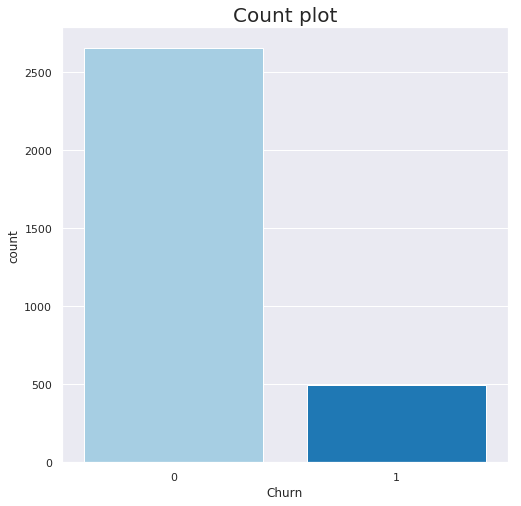

In [6]:
countplot('Churn',churn_df)

<b> *Challenge of working with imbalanced datasets:* </b>
<br>    Most machine learning techniques will ignore, and in turn have poor performance on, the minority class
<br> Biased predictions
<br> Misleading accuracy

<b> *Ways to addressing imbalanced datasets:* </b>

<b> Synthetic Minority Oversampling Technique </b>
<br>  It involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

<b> Balance the classes by increasing minority or decreasing majority </b>

<b> Random Under-sampling</b>
- Randomly remove majority class observations
- Helps balance the dataset
- Discarded observations could have important information
- May lead to bias

<b> Undersampling majority dataset</b>
- Randomly add more minority observations by replication
- No information loss
- Prone to overfitting due to copying same information

#### **Applying StratifiedShuffleSplit on the dataset**

**Why StratifiedShuffleSplit?** For model evaluation we often use train_test_split from sklearn to split the data into train set and test set. This is fine if the sample size is large. If the sample size is small we cannot expect the same. It will make sure that the data is split in a way that the splits will have equal proportions of the classes If it is not so then we are training on one distribution and predicting from another distribution!

In [7]:
# cross-validation with 5 splits
cv = StratifiedShuffleSplit(n_splits=5, random_state = 88)
#split the data
X = churn_df.iloc[:,:11]
#store the output variable in y
y = churn_df.iloc[:,11]

#### **Feature scaling**
**Min-Max scaling** Min-max scaling will replace every value in a column with a new value using a formula(m = (x -xmin) / (xmax -xmin). The purpose behind this is to get the values of all columns in the same range i.e [0-1]

In [8]:
# Scaling data to 0 to 1
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
# split data to X train/test and Y train/test
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

### Applying SMOTE technique

In [9]:
# Applying SMOTE technique
sm = SMOTE(random_state=12, sampling_strategy = 1.0)
X_smote, y_smote  = sm.fit_resample(X, y)
X_smote_train, X_smote_test, Y_smote_train, Y_smote_test = train_test_split(X_smote, y_smote, test_size=0.30, random_state=42, stratify = y_smote)

In [10]:
# Checking if the data is balanced or not
counter = Counter(y_smote)
print(counter)

Counter({0: 2655, 1: 2655})


Here, after applying SMOTE we treat the imbalanced data and we are able to get same number of values for both the categories i.e, churn and non-churn

In [11]:
#scale smote data
scaler = MinMaxScaler()
scaler.fit(X_smote)
X_scaled_smote = scaler.transform(X_smote)

In [12]:
# split data to X train/test and Y train/test
X_smote_train, X_smote_test, Y_smote_train, Y_smote_test = train_test_split(X_scaled_smote, y_smote, test_size=0.30, random_state=100, stratify = y_smote)

### Resampling technique - Undersampling

<b> *Under-sampling balances the dataset by reducing the size of the abundant class* </b>

In [13]:
# class count
class_count_0, class_count_1 = churn_df['Churn'].value_counts()
# divide class into two dataframes in a way, where one dataframe contains data where churn = 0 and other has data containing churn = 1)
class_0 = churn_df[churn_df['Churn'] == 0]
class_1 = churn_df[churn_df['Churn'] == 1]
# print the shape of the class
print('class 0:', class_0.shape)
print('\nclass 1:', class_1.shape)

class 0: (2655, 12)

class 1: (495, 12)


total class of 1 and 0:
 1    495
0    495
Name: Churn, dtype: int64


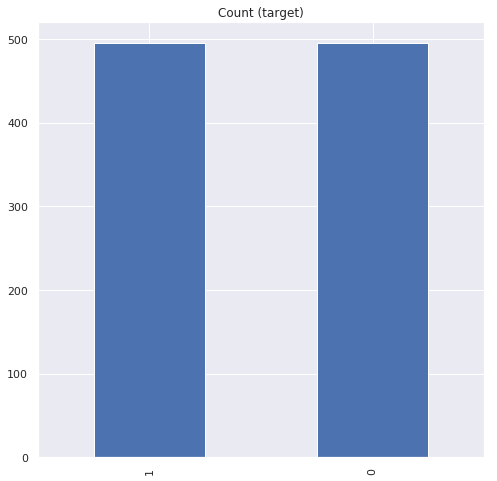

In [14]:
# Undersample the majority class, class_count_0, to the same count as class_count_1.
class_0_under = class_0.sample(class_count_1)
#Concatenating both the dataframes(One containing data where  Churn=0 and other containing data where Churn = 1) into a dataframe
test_under = pd.concat([class_0_under, class_1], axis=0)
# Print total number of samples in each class to check if data is balanced
print("total class of 1 and 0:\n",test_under['Churn'].value_counts())
# Let's visualize and check for data imbalance
test_under['Churn'].value_counts().plot(kind='bar', title='Count (target)')
plt.savefig('./images/churnCount.png')
plt.show()

In [15]:
#split the data
X = test_under.iloc[:,:11]
#store the output variable in y
y = test_under.iloc[:,11]
# Scaling data to 0 to 1
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
# split data to X train/test and Y train/test
X_train_undersampling, X_test_undersampling, Y_train_undersampling, Y_test_undersampling = train_test_split(X, y, test_size=0.30, random_state=100, stratify = y)

In [16]:
# display test scores and return result string and indexes of false samples
def display_test_scores(test, pred,pred1):
    str_out = "\n"
    str_out += ("#####  TEST SCORES  #####\n--------------------")
    str_out += ("\n")

    #print accuracy
    accuracy = accuracy_score(test, pred)
    str_out += ("ACCURACY: {:.4f}\n".format(accuracy))
    str_out += ("\n")

    #print AUC score
    auc = roc_auc_score(test, pred1[:,1])
    str_out += ("AUC: {:.4f}\n".format(auc))
    
    #print confusion matrix
    str_out += ("CONFUSION MATRIX:\n--------------------\n")
    conf_mat = confusion_matrix(test, pred)
    str_out += ("{}".format(conf_mat))
    str_out += ("\n")
    str_out += ("\n--------------------\n")

    #print classification report
    str_out += ("{}".format(classification_report(test, pred)))
    
    false_indexes = np.where(test != pred)
    return str_out, false_indexes

## **Model building**

**XGBOOST** XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. Where the idea is to boost weak learners by minimizing errors by gradient descent algorithm. Considered very efficient and fast compared to other algorithms

### XGBoost model without sampling


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.9407

AUC: 0.9764
CONFUSION MATRIX:
--------------------
[[776  21]
 [ 35 113]]

--------------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       797
           1       0.84      0.76      0.80       148

    accuracy                           0.94       945
   macro avg       0.90      0.87      0.88       945
weighted avg       0.94      0.94      0.94       945

Accuracy: 0.940741
Precision: 0.843284
Recall: 0.763514
F1 score: 0.801418


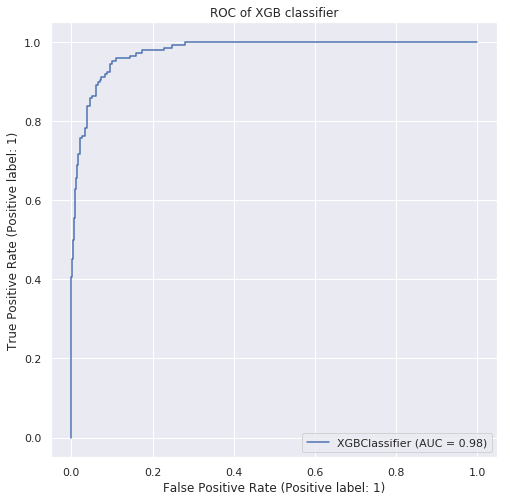


Observation: 
Built this model with imbalance data and as XGBoost can offer better performance on binary classification problems with a severe class imbalance, here we observe that the model is performing well and has good precision as well as recall score


In [17]:
# Train xgbclassifier on train data
xgb = XGBClassifier(eval_metric='mlogloss')
# Fit xgbclassifier on train data
xgb.fit(X_train, Y_train)
# make predictions for test data
y_pred = xgb.predict(X_test)
y_pred_prob = xgb.predict_proba(X_test)

predictions = [round(value) for value in y_pred]
# evaluate predictions
results, false = display_test_scores(Y_test, predictions,y_pred_prob)
print(results)
# accuracy: (tp + tn) / (p + n)
acc_xgb = accuracy_score(Y_test,predictions)
print('Accuracy: %f' % acc_xgb)
# precision tp / (tp + fp)
prec_xgb = precision_score(Y_test,predictions)
print('Precision: %f' % prec_xgb)
# recall: tp / (tp + fn)
recall_xgb = recall_score(Y_test,predictions)
print('Recall: %f' % recall_xgb)
# f1: 2 tp / (2 tp + fp + fn)
f1_xgb = f1_score(Y_test,predictions)
print('F1 score: %f' % f1_xgb)
#plot ROC curve
metrics.plot_roc_curve(xgb, X_test, Y_test)
plt.title("ROC of XGB classifier")
plt.savefig('./images/ROC_XGBClassifier.png')
plt.show()
print("\n\033[1mObservation: \033[0m\nBuilt this model with imbalance data and as XGBoost can offer better performance on binary classification problems with a severe class imbalance, here we observe that the model is performing well and has good precision as well as recall score")


### XGBoost model with SMOTE 


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.9686

AUC: 0.9953
CONFUSION MATRIX:
--------------------
[[769  28]
 [ 22 774]]

--------------------
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       797
           1       0.97      0.97      0.97       796

    accuracy                           0.97      1593
   macro avg       0.97      0.97      0.97      1593
weighted avg       0.97      0.97      0.97      1593

Accuracy: 0.968613
Precision: 0.965087
Recall: 0.972362
F1 score: 0.968711


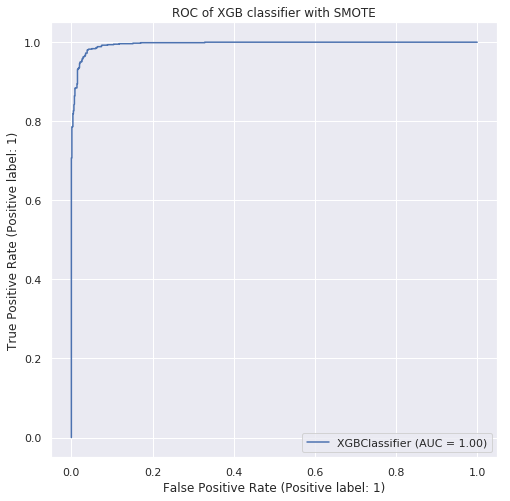


Observation: 
 Built this model with balance data(generated using SMOTE) and here we observe that the model is performing better that previous model which was built on imbalanced data even the aread under the curve has increased from 97.64 to 99.53. Also, the model's f1-score is better(96%) than the previous model(80%)


In [18]:
# Train xgbclassifier on smote_train data
xgb_smote_clf = XGBClassifier(eval_metric='mlogloss')
# Fit xgbclassifier on smote_train data
xgb_smote_clf.fit(X_smote_train,Y_smote_train)
# make predictions for test data
y_pred = xgb_smote_clf.predict(X_smote_test)
y_pred_prob = xgb_smote_clf.predict_proba(X_smote_test)

predictions = [round(value) for value in y_pred]
# evaluate predictions
results, false = display_test_scores(Y_smote_test, predictions,y_pred_prob)
print(results)
# accuracy: (tp + tn) / (p + n)
acc_xgb_smote = accuracy_score(Y_smote_test,predictions)
print('Accuracy: %f' % acc_xgb_smote)
# precision tp / (tp + fp)
prec_xgb_smote = precision_score(Y_smote_test,predictions)
print('Precision: %f' % prec_xgb_smote)
# recall: tp / (tp + fn)
recall_xgb_smote = recall_score(Y_smote_test,predictions)
print('Recall: %f' % recall_xgb_smote)
# f1: 2 tp / (2 tp + fp + fn)
f1_xgb_smote = f1_score(Y_smote_test,predictions)
print('F1 score: %f' % f1_xgb_smote)
#plot ROC curve
metrics.plot_roc_curve(xgb_smote_clf, X_smote_test, Y_smote_test)
plt.title("ROC of XGB classifier with SMOTE")
plt.savefig('./images/ROC_XGBClassifierWithSMOTE.png')
plt.show()
print("\n\033[1mObservation: \033[0m\n Built this model with balance data(generated using SMOTE) and here we observe that the model is performing better that previous model which was built on imbalanced data even the aread under the curve has increased from 97.64 to 99.53. Also, the model's f1-score is better(96%) than the previous model(80%)")


### Hyperparameter tuning wrt SMOTE imputed data

<b> *Now Let's tune some of the parameters to increase the performance of our model by training it on best parameters generated by this following hyperparameter tuning process* </b>

In [19]:
n_estimators = [20,100, 500]
booster = ['gbtree','gblinear']
learning_rate = [0.1,0.20,0.02,0.05,0.01]
for i in n_estimators:
    for k in booster:
        for m in learning_rate:
            xgb = XGBClassifier(eval_metric='mlogloss',n_estimators = i,booster=k,learning_rate = m)
            # Fit xgbclassifier on train data
            xgb.fit(X_smote_train, Y_smote_train)
            # make predictions for test data
            y_pred = xgb.predict(X_smote_test)
            predictions = [round(value) for value in y_pred]
            # evaluate predictions
            accuracy = accuracy_score(Y_smote_test, predictions)
            #print("Accuracy: %.2f%%" % (accuracy * 100.0))
            if accuracy > 0.93:
                print("Best parameters: n_estimators = %d  booster = %s learning_rate = %f, accuracy = %.3f" % (i,k,m,accuracy))

Best parameters: n_estimators = 20  booster = gbtree learning_rate = 0.100000, accuracy = 0.931
Best parameters: n_estimators = 20  booster = gbtree learning_rate = 0.200000, accuracy = 0.936
Best parameters: n_estimators = 100  booster = gbtree learning_rate = 0.100000, accuracy = 0.960
Best parameters: n_estimators = 100  booster = gbtree learning_rate = 0.200000, accuracy = 0.966
Best parameters: n_estimators = 100  booster = gbtree learning_rate = 0.050000, accuracy = 0.945
Best parameters: n_estimators = 500  booster = gbtree learning_rate = 0.100000, accuracy = 0.964
Best parameters: n_estimators = 500  booster = gbtree learning_rate = 0.200000, accuracy = 0.965
Best parameters: n_estimators = 500  booster = gbtree learning_rate = 0.020000, accuracy = 0.961
Best parameters: n_estimators = 500  booster = gbtree learning_rate = 0.050000, accuracy = 0.970
Best parameters: n_estimators = 500  booster = gbtree learning_rate = 0.010000, accuracy = 0.941


<b> *After tuning the parameters, the best accuracy that was obtained is 96.6% and the best values for the parameters are as follow:*</b>
- n_estimators : 500
- booster : gbtree
- learning_rate : 0.05


### XGBoost model with SMOTE (Using best parameters obtained during hyperparameter tuning)


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.9699

AUC: 0.9950
CONFUSION MATRIX:
--------------------
[[764  33]
 [ 15 781]]

--------------------
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       797
           1       0.96      0.98      0.97       796

    accuracy                           0.97      1593
   macro avg       0.97      0.97      0.97      1593
weighted avg       0.97      0.97      0.97      1593

Accuracy: 0.969868
Precision: 0.959459
Recall: 0.981156
F1 score: 0.970186


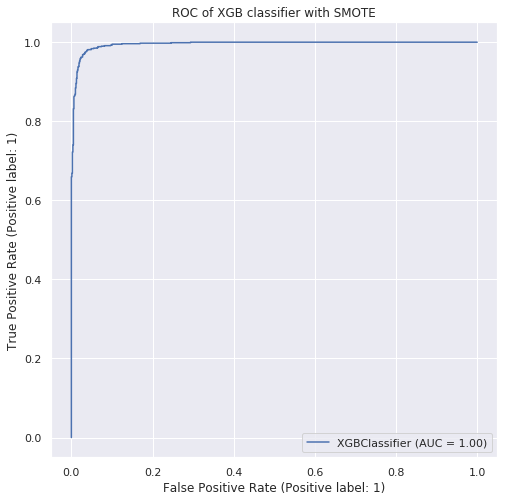


Observation: 
So far, this one is the best XGboost model wrt balance data generated via SMOTE, here we trained the model using the best parameters obtained using the previous hyperparameter tuning method also the model's accuracy increased from 96.86 to 96.99 and even the precision and recall of the model is improved. Also, the model's F1-score is better(97%) than the previous two models


In [20]:
# Train xgbclassifier on smote_train data
xgb_smote_clf = XGBClassifier(eval_metric='mlogloss',n_estimators = 500, booster = 'gbtree', learning_rate = 0.05)
# Fit xgbclassifier on smote_train data
xgb_smote_clf.fit(X_smote_train,Y_smote_train)
# make predictions for test data
y_pred = xgb_smote_clf.predict(X_smote_test)
y_pred_prob = xgb_smote_clf.predict_proba(X_smote_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
results, false = display_test_scores(Y_smote_test, predictions,y_pred_prob)
print(results)
# accuracy: (tp + tn) / (p + n)
acc_xgb_smote_best = accuracy_score(Y_smote_test,predictions)
print('Accuracy: %f' % acc_xgb_smote_best)
# precision tp / (tp + fp)
prec_xgb_smote_best = precision_score(Y_smote_test,predictions)
print('Precision: %f' % prec_xgb_smote_best)
# recall: tp / (tp + fn)
recall_xgb_smote_best = recall_score(Y_smote_test,predictions)
print('Recall: %f' % recall_xgb_smote_best)
# f1: 2 tp / (2 tp + fp + fn)
f1_xgb_smote_best = f1_score(Y_smote_test,predictions)
print('F1 score: %f' % f1_xgb_smote_best)
#plot ROC curve
metrics.plot_roc_curve(xgb_smote_clf, X_smote_test, Y_smote_test)
plt.title("ROC of XGB classifier with SMOTE")
plt.show()
print("\n\033[1mObservation: \033[0m\nSo far, this one is the best XGboost model wrt balance data generated via SMOTE, here we trained the model using the best parameters obtained using the previous hyperparameter tuning method also the model's accuracy increased from 96.86 to 96.99 and even the precision and recall of the model is improved. Also, the model's F1-score is better(97%) than the previous two models")

### XGBoost model on undersampling imputed data


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.9158

AUC: 0.9699
CONFUSION MATRIX:
--------------------
[[137  12]
 [ 13 135]]

--------------------
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       149
           1       0.92      0.91      0.92       148

    accuracy                           0.92       297
   macro avg       0.92      0.92      0.92       297
weighted avg       0.92      0.92      0.92       297

Accuracy: 0.915825
Precision: 0.918367
Recall: 0.912162
F1 score: 0.915254


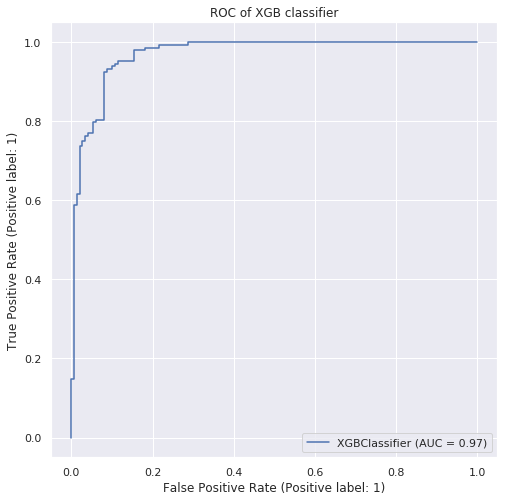


Observation: 
We built the model using the undersampling technique of treating class imbalance and it couldnt perform better than the model built using SMOTE imputed data. We can see a drop in the accuracy(90%) this could be due to loss of information because in undersampling it balances the dataset by reducing the size of the abundant data . Also, the f1 score isnt better(89%) than the previous model(97%). Also, area under the curve has dropped down to 95.9


In [21]:
# Train xgbclassifier on train_undersampling data
xgb = XGBClassifier(eval_metric='mlogloss')
# Fit xgbclassifier on train data
xgb.fit(X_train_undersampling, Y_train_undersampling)
# make predictions for test data
y_pred = xgb.predict(X_test_undersampling)
y_pred_prob = xgb.predict_proba(X_test_undersampling)
predictions = [round(value) for value in y_pred]
# evaluate predictions
results, false = display_test_scores(Y_test_undersampling, predictions,y_pred_prob)
print(results)
# accuracy: (tp + tn) / (p + n)
acc_xgb_undersampling = accuracy_score(Y_test_undersampling,predictions)
print('Accuracy: %f' % acc_xgb_undersampling)
# precision tp / (tp + fp)
prec_xgb_undersampling = precision_score(Y_test_undersampling,predictions)
print('Precision: %f' % prec_xgb_undersampling)
# recall: tp / (tp + fn)
recall_xgb_undersampling = recall_score(Y_test_undersampling,predictions)
print('Recall: %f' % recall_xgb_undersampling)
# f1: 2 tp / (2 tp + fp + fn)
f1_xgb_undersampling = f1_score(Y_test_undersampling,predictions)
print('F1 score: %f' % f1_xgb_undersampling)
#plot ROC curve
metrics.plot_roc_curve(xgb, X_test_undersampling, Y_test_undersampling)
plt.title("ROC of XGB classifier")
plt.savefig('./images/ROC_XGBClassifierUnderSampling.png')
plt.show()
print("\n\033[1mObservation: \033[0m\nWe built the model using the undersampling technique of treating class imbalance and it couldnt perform better than the model built using SMOTE imputed data. We can see a drop in the accuracy(90%) this could be due to loss of information because in undersampling it balances the dataset by reducing the size of the abundant data . Also, the f1 score isnt better(89%) than the previous model(97%). Also, area under the curve has dropped down to 95.9")

### **Naive-Bayes Classifier without sampling**

**Naïve Bayes**  Naive Bayes is a probabilistic machine learning algorithm based on the Bayes Theorem, used in a wide variety of classification tasks

**Gaussian Naive Bayes**  A Gaussian Naive Bayes algorithm is a sort of NB algorithm that is unique. When the features have continuous values, it's employed particularly. It's also expected that all of the characteristics have a gaussian distribution, or a normal distribution.

**Complement Naive Bayes**  Complement Naive Bayes is well-suited to dealing with unbalanced datasets. Instead of calculating the probability of an item belonging to a certain class, we calculate the probability of the item belonging to all classes in complement Naive Bayes.


*************************GaussianNB()****************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.6836

AUC: 0.8906
CONFUSION MATRIX:
--------------------
[[510 287]
 [ 12 136]]

--------------------
              precision    recall  f1-score   support

           0       0.98      0.64      0.77       797
           1       0.32      0.92      0.48       148

    accuracy                           0.68       945
   macro avg       0.65      0.78      0.62       945
weighted avg       0.87      0.68      0.73       945

Accuracy: 0.683598
Precision: 0.321513
Recall: 0.918919
F1 score: 0.476357


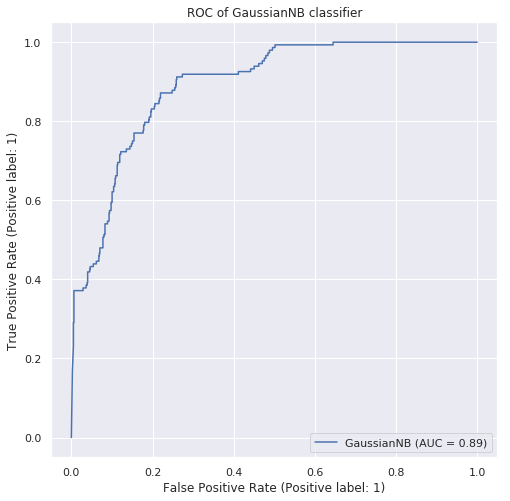


****************************MultinomialNB()*************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.8942

AUC: 0.8963
CONFUSION MATRIX:
--------------------
[[792   5]
 [ 95  53]]

--------------------
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       797
           1       0.91      0.36      0.51       148

    accuracy                           0.89       945
   macro avg       0.90      0.68      0.73       945
weighted avg       0.90      0.89      0.87       945

Accuracy: 0.894180
Precision: 0.913793
Recall: 0.358108
F1 score: 0.514563


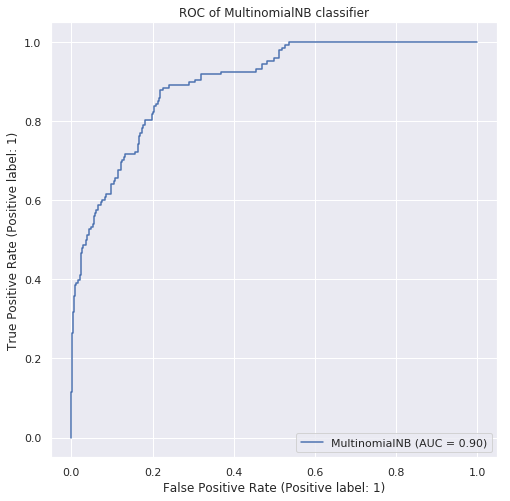


****************************ComplementNB_clf()*************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.8190

AUC: 0.8963
CONFUSION MATRIX:
--------------------
[[660 137]
 [ 34 114]]

--------------------
              precision    recall  f1-score   support

           0       0.95      0.83      0.89       797
           1       0.45      0.77      0.57       148

    accuracy                           0.82       945
   macro avg       0.70      0.80      0.73       945
weighted avg       0.87      0.82      0.84       945

Accuracy: 0.819048
Precision: 0.454183
Recall: 0.770270
F1 score: 0.571429


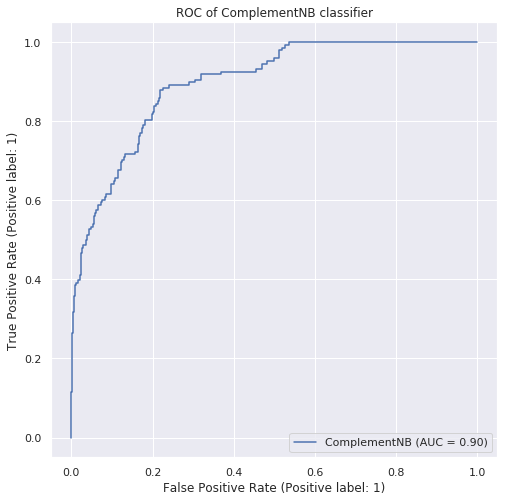


Observation1: 
 Built this model with imbalance data and used GaussianNB classifier and was able to achieve 68% accuracy,but precision score is low. F1-score is too low(47%), which is a clear indication of poor performance of the model

Observation2: 
 Built this model with imbalance data and used Multinomial classifier and was able to achieve 89%% accuracy. As you can see area under the curve is 89.63% which is better than the one we got using Gaussian model.

Observation3: 
 Built this model with imbalance data and used ComplementNB classifier and was able to achieve 81% accuracy, but the area under the curve is 89.63%. Although there is an improvement in the f1-score(57%) it is still low

Observation3: 
 Out of the three models, MultinomialNB seems to be better with regard to precision,recall,f1-score and AUC scores


In [22]:
# Naive-Bayes with different approaches
# fit GaussianNB classifier
# grid search for parameters
gaussian_clf = GaussianNB()
gaussian_clf.fit(X_train, Y_train)



# print best scores
# print("The best parameters are %s with a score of %0.4f\n"
#       % (gaussian_clf.best_params_, gaussian_clf.best_score_))

# prediction results
y_pred = gaussian_clf.predict(X_test)
y_pred_prob = gaussian_clf.predict_proba(X_test)

# print accuracy metrics
results, false = display_test_scores(Y_test, y_pred,y_pred_prob)
print("\n*************************GaussianNB()****************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_gaussian_clf = accuracy_score(Y_test,y_pred)
print('Accuracy: %f' % acc_gaussian_clf)
# precision tp / (tp + fp)
prec_gaussian_clf = precision_score(Y_test,y_pred)
print('Precision: %f' % prec_gaussian_clf)
# recall: tp / (tp + fn)
recall_gaussian_clf = recall_score(Y_test,y_pred)
print('Recall: %f' % recall_gaussian_clf)
# f1: 2 tp / (2 tp + fp + fn)
f1_gaussian_clf = f1_score(Y_test,y_pred)
print('F1 score: %f' % f1_gaussian_clf)

#plot ROC curve
metrics.plot_roc_curve(gaussian_clf, X_test, Y_test)
plt.title("ROC of GaussianNB classifier")
plt.savefig('./images/ROC_GaussianNB_Classifier.png')
plt.show()


#====================================================================================================

# fit MultinomialNB classifier
Multinomial_clf = MultinomialNB()
Multinomial_clf.fit(X_train, Y_train)

y_pred = Multinomial_clf.predict(X_test)
y_pred_prob = Multinomial_clf.predict_proba(X_test)

# print accuracy metrics
results, false = display_test_scores(Y_test, y_pred,y_pred_prob)
print("\n****************************MultinomialNB()*************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_Multinomial_clf = accuracy_score(Y_test,y_pred)
print('Accuracy: %f' % acc_Multinomial_clf)
# precision tp / (tp + fp)
prec_Multinomial_clf = precision_score(Y_test,y_pred)
print('Precision: %f' % prec_Multinomial_clf)
# recall: tp / (tp + fn)
recall_Multinomial_clf = recall_score(Y_test,y_pred)
print('Recall: %f' % recall_Multinomial_clf)
# f1: 2 tp / (2 tp + fp + fn)
f1_Multinomial_clf = f1_score(Y_test,y_pred)
print('F1 score: %f' % f1_Multinomial_clf)
#plot ROC curve
metrics.plot_roc_curve(Multinomial_clf, X_test, Y_test)
plt.title("ROC of MultinomialNB classifier")
plt.savefig('./images/ROC_MultinomialNB_Classifier.png')
plt.show()



#====================================================================================================

ComplementNB_clf = ComplementNB()
ComplementNB_clf.fit(X_train, Y_train)


# print best scores
# print("The best parameters are %s with a score of %0.4f\n"
#       % (Multinomial_clf.best_params_, Multinomial_clf.best_score_))

# prediction results
y_pred = ComplementNB_clf.predict(X_test)
y_pred_prob = ComplementNB_clf.predict_proba(X_test)

# print accuracy metrics
results, false = display_test_scores(Y_test, y_pred,y_pred_prob)
print("\n****************************ComplementNB_clf()*************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_ComplementNB_clf = accuracy_score(Y_test,y_pred)
print('Accuracy: %f' % acc_ComplementNB_clf)
# precision tp / (tp + fp)
prec_ComplementNB_clf = precision_score(Y_test,y_pred)
print('Precision: %f' % prec_ComplementNB_clf)
# recall: tp / (tp + fn)
recall_ComplementNB_clf = recall_score(Y_test,y_pred)
print('Recall: %f' % recall_ComplementNB_clf)
# f1: 2 tp / (2 tp + fp + fn)
f1_ComplementNB_clf = f1_score(Y_test,y_pred)
print('F1 score: %f' % f1_ComplementNB_clf)
#plot ROC curve
metrics.plot_roc_curve(ComplementNB_clf, X_test, Y_test)
plt.title("ROC of ComplementNB classifier")
plt.savefig('./images/ROC_ComplementNB_Classifier.png')
plt.show()
print("\n\033[1mObservation1: \033[0m\n Built this model with imbalance data and used GaussianNB classifier and was able to achieve 68% accuracy,but precision score is low. F1-score is too low(47%), which is a clear indication of poor performance of the model")
print("\n\033[1mObservation2: \033[0m\n Built this model with imbalance data and used Multinomial classifier and was able to achieve 89%% accuracy. As you can see area under the curve is 89.63% which is better than the one we got using Gaussian model.")
print("\n\033[1mObservation3: \033[0m\n Built this model with imbalance data and used ComplementNB classifier and was able to achieve 81% accuracy, but the area under the curve is 89.63%. Although there is an improvement in the f1-score(57%) it is still low")
print("\n\033[1mObservation3: \033[0m\n Out of the three models, MultinomialNB seems to be better with regard to precision,recall,f1-score and AUC scores")

### Naive-Bayes Classifier using SMOTE sampling


*************************GaussianNB() with SMOTE sampling****************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.7652

AUC: 0.8984
CONFUSION MATRIX:
--------------------
[[474 323]
 [ 51 745]]

--------------------
              precision    recall  f1-score   support

           0       0.90      0.59      0.72       797
           1       0.70      0.94      0.80       796

    accuracy                           0.77      1593
   macro avg       0.80      0.77      0.76      1593
weighted avg       0.80      0.77      0.76      1593

Accuracy: 0.765223
Precision: 0.697566
Recall: 0.935930
F1 score: 0.799356


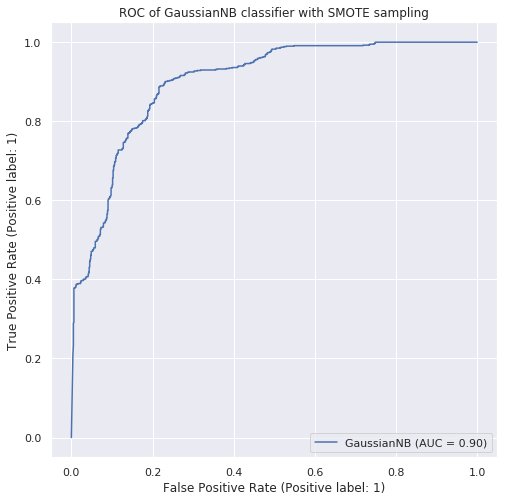


****************************MultinomialNB() with SMOTE sampling*************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.8148

AUC: 0.9103
CONFUSION MATRIX:
--------------------
[[662 135]
 [160 636]]

--------------------
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       797
           1       0.82      0.80      0.81       796

    accuracy                           0.81      1593
   macro avg       0.82      0.81      0.81      1593
weighted avg       0.82      0.81      0.81      1593

Accuracy: 0.814815
Precision: 0.824903
Recall: 0.798995
F1 score: 0.811742


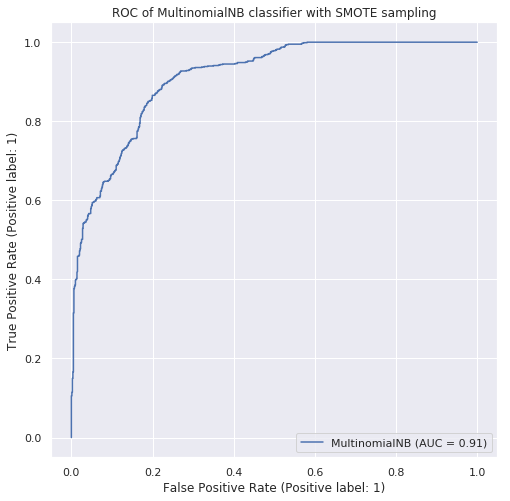


****************************ComplementNB() with SMOTE sampling*************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.8142

AUC: 0.9103
CONFUSION MATRIX:
--------------------
[[662 135]
 [161 635]]

--------------------
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       797
           1       0.82      0.80      0.81       796

    accuracy                           0.81      1593
   macro avg       0.81      0.81      0.81      1593
weighted avg       0.81      0.81      0.81      1593

Accuracy: 0.814187
Precision: 0.824675
Recall: 0.797739
F1 score: 0.810983


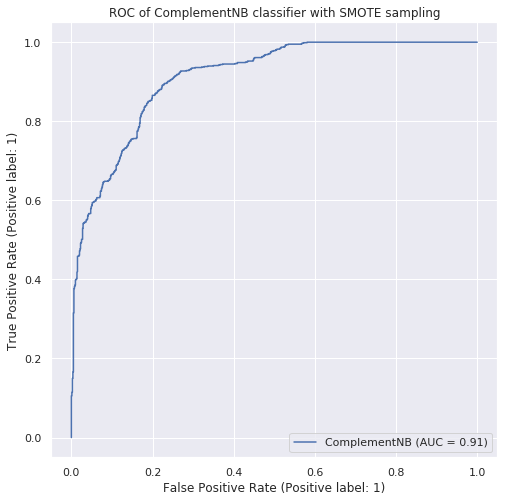


Observation1: 
 Built this model with balance data generated using SMOTE technique and used GaussianNB classifier and was able to achieve 76% accuracy, which is an improvement from the previous version where we worked on imbalanced data. We can see an improvement in the precision and recall scores as well. The f1-score of this model is much better(79%) than the previous version

Observation2: 
 Built this model with balance data and used Multinomial classifier and was able to achieve 81% accuracy and area under the curve is 91% which is an improvement from the previous version as earlier we worked with imbalance data and MultinomialNB classifier doesnt work that well on imbalance data. Now that the data is balanced, we see an improvement in the score. Even precision and recall values are much better. The f1-score of this model is much better(81%) than the previous version, as multinomialNB doesnt work that good on imbalance data

Observation3: 
 Built this model with balance data and 

In [23]:
# Naive-Bayes with different approaches
# fit GaussianNB classifier
gaussian_clf = GaussianNB()
gaussian_clf.fit(X_smote_train, Y_smote_train)
y_pred = gaussian_clf.predict(X_smote_test)
y_pred_prob = gaussian_clf.predict_proba(X_smote_test)

# print accuracy metrics
results, false = display_test_scores(Y_smote_test, y_pred,y_pred_prob)
print("\n*************************GaussianNB() with SMOTE sampling****************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_gaussian_clf_smote = accuracy_score(Y_smote_test,y_pred)
print('Accuracy: %f' % acc_gaussian_clf_smote)
# precision tp / (tp + fp)
prec_gaussian_clf_smote = precision_score(Y_smote_test,y_pred)
print('Precision: %f' % prec_gaussian_clf_smote)
# recall: tp / (tp + fn)
recall_gaussian_clf_smote = recall_score(Y_smote_test,y_pred)
print('Recall: %f' % recall_gaussian_clf_smote)
# f1: 2 tp / (2 tp + fp + fn)
f1_gaussian_clf_smote = f1_score(Y_smote_test,y_pred)
print('F1 score: %f' % f1_gaussian_clf_smote)


#plot ROC curve
metrics.plot_roc_curve(gaussian_clf, X_smote_test, Y_smote_test)
plt.title("ROC of GaussianNB classifier with SMOTE sampling")
plt.savefig('./images/ROC_GaussianNB_Classifier_withSMOTE.png')
plt.show()


#====================================================================================================

# fit MultinomialNB classifier
Multinomial_clf = MultinomialNB()
Multinomial_clf.fit(X_smote_train, Y_smote_train)

# prediction results
y_pred = Multinomial_clf.predict(X_smote_test)
y_pred_prob = Multinomial_clf.predict_proba(X_smote_test)

# print accuracy metrics
results, false = display_test_scores(Y_smote_test, y_pred,y_pred_prob)
print("\n****************************MultinomialNB() with SMOTE sampling*************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_Multinomial_clf_smote = accuracy_score(Y_smote_test,y_pred)
print('Accuracy: %f' % acc_Multinomial_clf_smote)
# precision tp / (tp + fp)
prec_Multinomial_clf_smote = precision_score(Y_smote_test,y_pred)
print('Precision: %f' % prec_Multinomial_clf_smote)
# recall: tp / (tp + fn)
recall_Multinomial_clf_smote = recall_score(Y_smote_test,y_pred)
print('Recall: %f' % recall_Multinomial_clf_smote)
# f1: 2 tp / (2 tp + fp + fn)
f1_Multinomial_clf_smote = f1_score(Y_smote_test,y_pred)
print('F1 score: %f' % f1_Multinomial_clf_smote)


#plot ROC curve
metrics.plot_roc_curve(Multinomial_clf, X_smote_test, Y_smote_test)
plt.title("ROC of MultinomialNB classifier with SMOTE sampling")
plt.savefig('./images/ROC_MultinominalNB_Classifier_withSMOTE.png')
plt.show()



#====================================================================================================

ComplementNB_clf = ComplementNB()
ComplementNB_clf.fit(X_smote_train, Y_smote_train)

# prediction results
y_pred = ComplementNB_clf.predict(X_smote_test)
y_pred_prob = ComplementNB_clf.predict_proba(X_smote_test)

# print accuracy metrics
results, false = display_test_scores(Y_smote_test, y_pred,y_pred_prob)
print("\n****************************ComplementNB() with SMOTE sampling*************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_ComplementNB_clf_smote = accuracy_score(Y_smote_test,y_pred)
print('Accuracy: %f' % acc_ComplementNB_clf_smote)
# precision tp / (tp + fp)
prec_ComplementNB_clf_smote = precision_score(Y_smote_test,y_pred)
print('Precision: %f' % prec_ComplementNB_clf_smote)
# recall: tp / (tp + fn)
recall_ComplementNB_clf_smote = recall_score(Y_smote_test,y_pred)
print('Recall: %f' % recall_ComplementNB_clf_smote)
# f1: 2 tp / (2 tp + fp + fn)
f1_ComplementNB_clf_smote = f1_score(Y_smote_test,y_pred)
print('F1 score: %f' % f1_ComplementNB_clf_smote)

#plot ROC curve
metrics.plot_roc_curve(ComplementNB_clf, X_smote_test, Y_smote_test)
plt.title("ROC of ComplementNB classifier with SMOTE sampling")
plt.savefig('./images/ROC_ComplementNB_Classifier_withSMOTE.png')
plt.show()
print("\n\033[1mObservation1: \033[0m\n Built this model with balance data generated using SMOTE technique and used GaussianNB classifier and was able to achieve 76% accuracy, which is an improvement from the previous version where we worked on imbalanced data. We can see an improvement in the precision and recall scores as well. The f1-score of this model is much better(79%) than the previous version")
print("\n\033[1mObservation2: \033[0m\n Built this model with balance data and used Multinomial classifier and was able to achieve 81% accuracy and area under the curve is 91% which is an improvement from the previous version as earlier we worked with imbalance data and MultinomialNB classifier doesnt work that well on imbalance data. Now that the data is balanced, we see an improvement in the score. Even precision and recall values are much better. The f1-score of this model is much better(81%) than the previous version, as multinomialNB doesnt work that good on imbalance data")
print("\n\033[1mObservation3: \033[0m\n Built this model with balance data and used ComplementNB classifier and was able to achieve 81% accuracy, even the area under the curve is comparitively more(91%) than the one we got in the previous model(89%). There is an improvement in the f1-score(81%) as compared to the previous model")
print("\n\033[1mObservation3: \033[0m\n Out of the three models, MultinomialNB seems to be better with regard to precision,recall,f1-score and AUC scores")

### Naive-Bayes model on undersampling imputed data


*************************GaussianNB() with undersampling sampling****************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.7879

AUC: 0.9056
CONFUSION MATRIX:
--------------------
[[ 95  54]
 [  9 139]]

--------------------
              precision    recall  f1-score   support

           0       0.91      0.64      0.75       149
           1       0.72      0.94      0.82       148

    accuracy                           0.79       297
   macro avg       0.82      0.79      0.78       297
weighted avg       0.82      0.79      0.78       297

Accuracy: 0.787879
Precision: 0.720207
Recall: 0.939189
F1 score: 0.815249


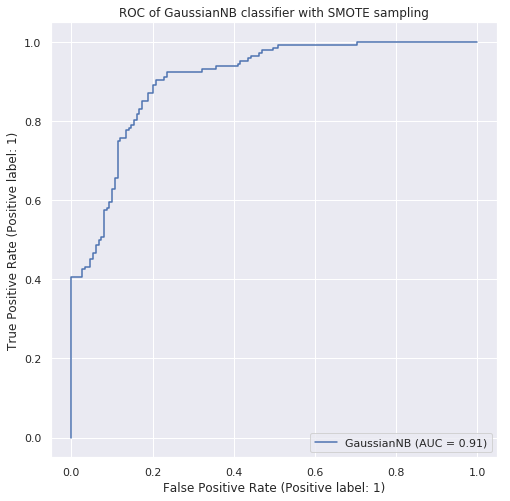


****************************MultinomialNB() with undersampling sampling*************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.8114

AUC: 0.9147
CONFUSION MATRIX:
--------------------
[[125  24]
 [ 32 116]]

--------------------
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       149
           1       0.83      0.78      0.81       148

    accuracy                           0.81       297
   macro avg       0.81      0.81      0.81       297
weighted avg       0.81      0.81      0.81       297

Accuracy: 0.811448
Precision: 0.828571
Recall: 0.783784
F1 score: 0.805556


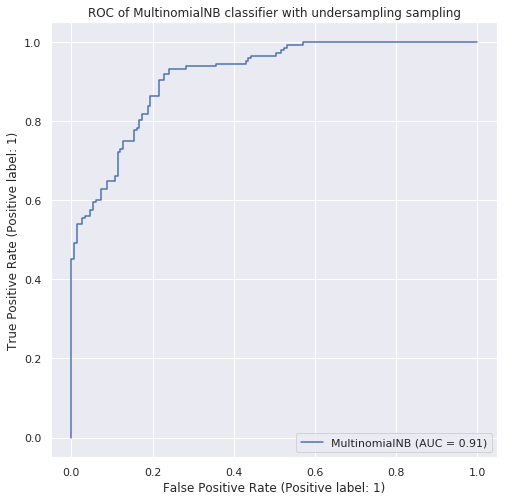


****************************ComplementNB() with undersampling sampling*************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.8114

AUC: 0.9147
CONFUSION MATRIX:
--------------------
[[125  24]
 [ 32 116]]

--------------------
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       149
           1       0.83      0.78      0.81       148

    accuracy                           0.81       297
   macro avg       0.81      0.81      0.81       297
weighted avg       0.81      0.81      0.81       297

Accuracy: 0.811448
Precision: 0.828571
Recall: 0.783784
F1 score: 0.805556


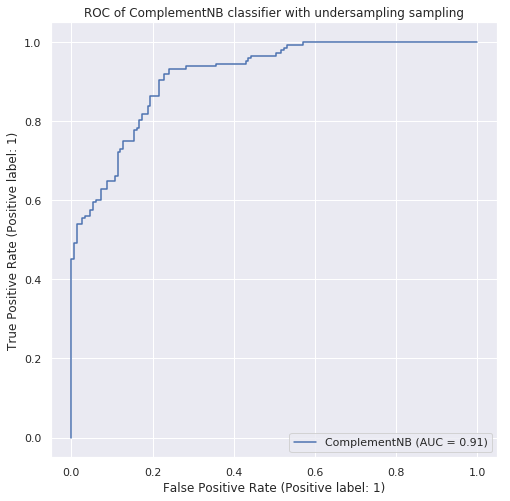


Observation1: 
 Built this model with balance data generated using undersampling technique and used GaussianNB classifier and was able to achieve 73% accuracy, which is not an improvement from the previous version(76%). The model's f1-score is lower(78%) than the previous model(79.99%)

Observation2: 
 Built this model with balance data and used Multinomial classifier and was able to achieve 80% accuracy and area under the curve is 90% which is not an improvement from the previous version(91%). The f1-score is lower(80%) than the previous model(81)

Observation2: 
 Built this model with balance data and used ComplementNB classifier and was able to achieve 80% accuracy and area under the curve is 90% which is not an improvement from the previous version. The f1-score is lower(80%) than the previous model(81

Observation3: 
 Out of the three models, MultinomialNB as well as ComplementNB seems to be better with regard to precision,recall and AUC scores. Also, SMOTE technique seems to be 

In [25]:
# Naive-Bayes with different approaches
# fit GaussianNB classifier
gaussian_clf = GaussianNB()
gaussian_clf.fit(X_train_undersampling, Y_train_undersampling)
y_pred = gaussian_clf.predict(X_test_undersampling)
y_pred_prob = gaussian_clf.predict_proba(X_test_undersampling)

# print accuracy metrics
results, false = display_test_scores(Y_test_undersampling, y_pred,y_pred_prob)
print("\n*************************GaussianNB() with undersampling sampling****************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_gaussian_clf_undersampling = accuracy_score(Y_test_undersampling,y_pred)
print('Accuracy: %f' % acc_gaussian_clf_undersampling)
# precision tp / (tp + fp)
prec_gaussian_clf_undersampling = precision_score(Y_test_undersampling,y_pred)
print('Precision: %f' % prec_gaussian_clf_undersampling)
# recall: tp / (tp + fn)
recall_gaussian_clf_undersampling = recall_score(Y_test_undersampling,y_pred)
print('Recall: %f' % recall_gaussian_clf_undersampling)
# f1: 2 tp / (2 tp + fp + fn)
f1_gaussian_clf_undersampling = f1_score(Y_test_undersampling,y_pred)
print('F1 score: %f' % f1_gaussian_clf_undersampling)

#plot ROC curve
metrics.plot_roc_curve(gaussian_clf, X_test_undersampling, Y_test_undersampling)
plt.title("ROC of GaussianNB classifier with SMOTE sampling")
plt.savefig('ROC_GaussianNB_Classifier_withundersampling.png')
plt.show()


#====================================================================================================

# fit MultinomialNB classifier
Multinomial_clf = MultinomialNB()
Multinomial_clf.fit(X_train_undersampling, Y_train_undersampling)

# prediction results
y_pred = Multinomial_clf.predict(X_test_undersampling)
y_pred_prob = Multinomial_clf.predict_proba(X_test_undersampling)

# print accuracy metrics
results, false = display_test_scores(Y_test_undersampling, y_pred,y_pred_prob)
print("\n****************************MultinomialNB() with undersampling sampling*************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_Multinomial_clf_undersampling = accuracy_score(Y_test_undersampling,y_pred)
print('Accuracy: %f' % acc_Multinomial_clf_undersampling)
# precision tp / (tp + fp)
prec_Multinomial_clf_undersampling = precision_score(Y_test_undersampling,y_pred)
print('Precision: %f' % prec_Multinomial_clf_undersampling)
# recall: tp / (tp + fn)
recall_Multinomial_clf_undersampling = recall_score(Y_test_undersampling,y_pred)
print('Recall: %f' % recall_Multinomial_clf_undersampling)
# f1: 2 tp / (2 tp + fp + fn)
f1_Multinomial_clf_undersampling = f1_score(Y_test_undersampling,y_pred)
print('F1 score: %f' % f1_Multinomial_clf_undersampling)

#plot ROC curve
metrics.plot_roc_curve(Multinomial_clf, X_test_undersampling, Y_test_undersampling)
plt.title("ROC of MultinomialNB classifier with undersampling sampling")
plt.savefig('ROC_MultinominalNB_Classifier_withundersampling.png')
plt.show()



#====================================================================================================

ComplementNB_clf = ComplementNB()
ComplementNB_clf.fit(X_train_undersampling, Y_train_undersampling)

# prediction results
y_pred = ComplementNB_clf.predict(X_test_undersampling)
y_pred_prob = ComplementNB_clf.predict_proba(X_test_undersampling)

# print accuracy metrics
results, false = display_test_scores(Y_test_undersampling, y_pred,y_pred_prob)
print("\n****************************ComplementNB() with undersampling sampling*************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_ComplementNB_clf_undersampling = accuracy_score(Y_test_undersampling,y_pred)
print('Accuracy: %f' % acc_ComplementNB_clf_undersampling)
# precision tp / (tp + fp)
prec_ComplementNB_clf_undersampling = precision_score(Y_test_undersampling,y_pred)
print('Precision: %f' % prec_ComplementNB_clf_undersampling)
# recall: tp / (tp + fn)
recall_ComplementNB_clf_undersampling = recall_score(Y_test_undersampling,y_pred)
print('Recall: %f' % recall_ComplementNB_clf_undersampling)
# f1: 2 tp / (2 tp + fp + fn)
f1_ComplementNB_clf_undersampling = f1_score(Y_test_undersampling,y_pred)
print('F1 score: %f' % f1_ComplementNB_clf_undersampling)
#plot ROC curve
metrics.plot_roc_curve(ComplementNB_clf, X_test_undersampling, Y_test_undersampling)
plt.title("ROC of ComplementNB classifier with undersampling sampling")
plt.savefig('ROC_ComplementNB_Classifier_withundersampling.png')
plt.show()
print("\n\033[1mObservation1: \033[0m\n Built this model with balance data generated using undersampling technique and used GaussianNB classifier and was able to achieve 73% accuracy, which is not an improvement from the previous version(76%). The model's f1-score is lower(78%) than the previous model(79.99%)")
print("\n\033[1mObservation2: \033[0m\n Built this model with balance data and used Multinomial classifier and was able to achieve 80% accuracy and area under the curve is 90% which is not an improvement from the previous version(91%). The f1-score is lower(80%) than the previous model(81)")
print("\n\033[1mObservation2: \033[0m\n Built this model with balance data and used ComplementNB classifier and was able to achieve 80% accuracy and area under the curve is 90% which is not an improvement from the previous version. The f1-score is lower(80%) than the previous model(81")
print("\n\033[1mObservation3: \033[0m\n Out of the three models, MultinomialNB as well as ComplementNB seems to be better with regard to precision,recall and AUC scores. Also, SMOTE technique seems to be better than undersampling in this case")

### **SVM Classifier without sampling**
**Support vector machines** The Support Vector Machine, or SVM, is a linear model that can be used to solve classification and regression issues. It can solve both linear and nonlinear problems and is useful for a wide range of applications.  The algorithm generates a line or hyperplane that divides the data into categories.

**Grid searchcv** It can assist you in looping over predefined hyperparameters and fitting your estimator (model) to your training data. Finally, you can choose the most appropriate hyperparameters from the list.

The best parameters are {'C': 100, 'class_weight': None, 'kernel': 'rbf'} with a score of 0.9088


*************************SVM Classifier****************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.9037

AUC: 0.9161
CONFUSION MATRIX:
--------------------
[[784  13]
 [ 78  70]]

--------------------
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       797
           1       0.84      0.47      0.61       148

    accuracy                           0.90       945
   macro avg       0.88      0.73      0.78       945
weighted avg       0.90      0.90      0.89       945


Run time for train&test cv SVM :  27.680182218551636
Accuracy: 0.903704
Precision: 0.843373
Recall: 0.472973
F1 score: 0.606061


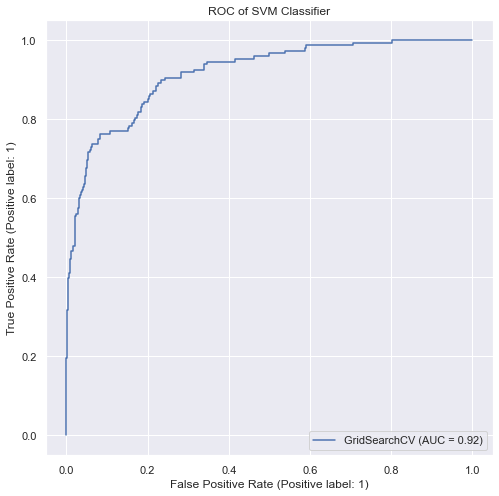


Observation: 
 Built this model with imbalance data and used SVM model and was able to achieve 90% accuracy by fitting the model with the best parameters obtained during the parameter tuning process by gridsearchcv. But, there is a scope of improvement wrt recall. The area under the curve is 91%. The f1-score for this model is 60%, there is room for improvement


In [25]:
# SVM Classifier with different approaches

# parameters 
parameters = {
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'class_weight': [None, 'balanced']
            }

start_time=time.time()

# grid search for parameters
#tol is the tolerance for stopping criteria
SVM_grid_clf = GridSearchCV(SVC(degree=5, max_iter=1000, tol=1e-5,probability = True), cv = 5, param_grid=parameters, n_jobs=-1, refit=True )
SVM_grid_clf.fit(X_train, Y_train)

# print best scores
print("The best parameters are %s with a score of %0.4f\n"
      % (SVM_grid_clf.best_params_, SVM_grid_clf.best_score_))

# prediction results
y_pred = SVM_grid_clf.predict(X_test)
y_pred_prob = SVM_grid_clf.predict_proba(X_test)

end_time=time.time()




# print accuracy metrics
results, false = display_test_scores(Y_test, y_pred,y_pred_prob)
print("\n*************************SVM Classifier****************************************\n")
print(results)

print("\nRun time for train&test cv SVM : ", end_time-start_time)

# accuracy: (tp + tn) / (p + n)
acc_svm_clf_undersampling = accuracy_score(Y_test,y_pred)
print('Accuracy: %f' % acc_svm_clf_undersampling)
# precision tp / (tp + fp)
prec_svm_clf_undersampling = precision_score(Y_test,y_pred)
print('Precision: %f' % prec_svm_clf_undersampling)
# recall: tp / (tp + fn)
recall_svm_clf_undersampling = recall_score(Y_test,y_pred)
print('Recall: %f' % recall_svm_clf_undersampling)
# f1: 2 tp / (2 tp + fp + fn)
f1_svm_clf_undersampling = f1_score(Y_test,y_pred)
print('F1 score: %f' % f1_svm_clf_undersampling)
#plot ROC curve
metrics.plot_roc_curve(SVM_grid_clf, X_test, Y_test)
plt.title("ROC of SVM Classifier")
plt.savefig('./images/ROC_SVM_Classifier.png')
plt.show()
print("\n\033[1mObservation: \033[0m\n Built this model with imbalance data and used SVM model and was able to achieve 90% accuracy by fitting the model with the best parameters obtained during the parameter tuning process by gridsearchcv. But, there is a scope of improvement wrt recall. The area under the curve is 91%. The f1-score for this model is 60%, there is room for improvement")

### SVM Classifier with SMOTE

The best parameters are {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'} with a score of 0.8749


Run time for train&test cv SVM :  78.9753520488739

*************************SVM Classifier****************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.8562

AUC: 0.9279
CONFUSION MATRIX:
--------------------
[[640 157]
 [ 72 724]]

--------------------
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       797
           1       0.82      0.91      0.86       796

    accuracy                           0.86      1593
   macro avg       0.86      0.86      0.86      1593
weighted avg       0.86      0.86      0.86      1593

Accuracy: 0.856246
Precision: 0.821793
Recall: 0.909548
F1 score: 0.863447


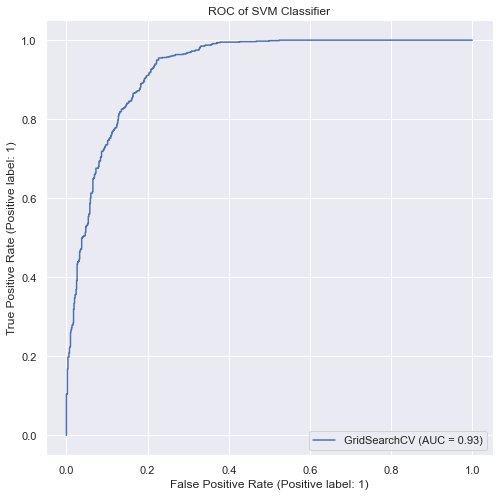


Observation: 
 Built this model with balance data generated using SMOTE technique and used SVM model and was able to achieve 87% accuracy. But there is an improvement wrt area under the curve(94%). Also, precision as well as recall scores are better as compared to the previous model. The model's f1-score has improved from 60 to 88% after correcting class imbalance


In [26]:

# SVM Classifier with different approaches

# parameters 
parameters = {
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'class_weight': [None, 'balanced']
            }

start_time=time.time()

# grid search for parameters
#tol is the tolerance for stopping criteria
SVM_grid_clf = GridSearchCV(SVC(degree=5, max_iter=1000,probability = True), cv = 5, param_grid=parameters, n_jobs=-1, refit=True )
SVM_grid_clf.fit(X_smote_train, Y_smote_train)

# print best scores
print("The best parameters are %s with a score of %0.4f\n"
      % (SVM_grid_clf.best_params_, SVM_grid_clf.best_score_))

# prediction results
y_pred = SVM_grid_clf.predict(X_smote_test)
y_pred_prob = SVM_grid_clf.predict_proba(X_smote_test)

end_time=time.time()

print("\nRun time for train&test cv SVM : ", end_time-start_time)


# print accuracy metrics
results, false = display_test_scores(Y_smote_test, y_pred,y_pred_prob)
print("\n*************************SVM Classifier****************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_svm_clf_smote = accuracy_score(Y_smote_test,y_pred)
print('Accuracy: %f' % acc_svm_clf_smote)
# precision tp / (tp + fp)
prec_svm_clf_smote = precision_score(Y_smote_test,y_pred)
print('Precision: %f' % prec_svm_clf_smote)
# recall: tp / (tp + fn)
recall_svm_clf_smote = recall_score(Y_smote_test,y_pred)
print('Recall: %f' % recall_svm_clf_smote)
# f1: 2 tp / (2 tp + fp + fn)
f1_svm_clf_smote = f1_score(Y_smote_test,y_pred)
print('F1 score: %f' % f1_svm_clf_smote)
#plot ROC curve
metrics.plot_roc_curve(SVM_grid_clf, X_smote_test, Y_smote_test)
plt.title("ROC of SVM Classifier")
plt.savefig('./images/ROC_SVM_Classifier_withSMOTE.png')
plt.show()
print("\n\033[1mObservation: \033[0m\n Built this model with balance data generated using SMOTE technique and used SVM model and was able to achieve 87% accuracy. But there is an improvement wrt area under the curve(94%). Also, precision as well as recall scores are better as compared to the previous model. The model's f1-score has improved from 60 to 88% after correcting class imbalance")

### SVM Classifier with undersampling

/Users/archie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/archie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/archie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/archie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with S

/Users/archie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/archie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/archie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/archie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with S

The best parameters are {'C': 100, 'class_weight': None, 'kernel': 'rbf'} with a score of 0.8557


Run time for train&test cv SVM :  3.8459818363189697

*************************SVM Classifier****************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.8485

AUC: 0.9244
CONFUSION MATRIX:
--------------------
[[118  31]
 [ 14 134]]

--------------------
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       149
           1       0.81      0.91      0.86       148

    accuracy                           0.85       297
   macro avg       0.85      0.85      0.85       297
weighted avg       0.85      0.85      0.85       297

Accuracy: 0.848485
Precision: 0.812121
Recall: 0.905405
F1 score: 0.856230


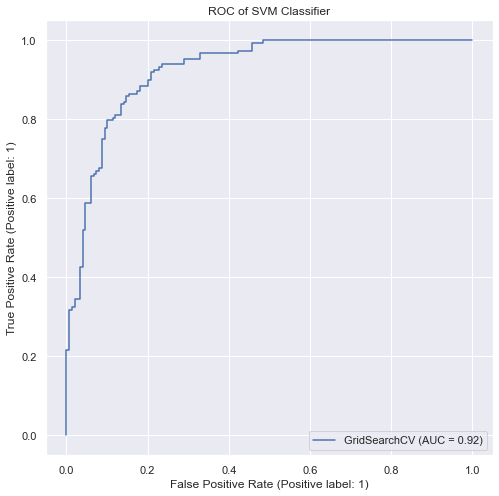


Observation: 
 Built this model with balance data generated using undersampling technique and used SVM model and was able to achieve 85% accuracy which is not better than the previous model whose accuracy is 87% and area under the curve is 92% which is less than the previous model(94%). Also, precision and recall values arent as good as the previous model's precision and recall values. The f1-score wrt to this model(85%) is not better than the previous model(88%) where we class imbalance was take care off using SMOTE technique 


In [27]:
# SVM Classifier with different approaches

# parameters 
parameters = {
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'class_weight': [None, 'balanced']
            }

start_time=time.time()

# grid search for parameters
#tol is the tolerance for stopping criteria
SVM_grid_clf = GridSearchCV(SVC(degree=5, max_iter=1000,probability = True), cv = 5, param_grid=parameters, n_jobs=-1, refit=True )
#tol is the tolerance for stopping criteria),cv = 5, param_grid=parameters, n_jobs=-1, refit=True )
SVM_grid_clf.fit(X_train_undersampling, Y_train_undersampling)

# print best scores
print("The best parameters are %s with a score of %0.4f\n"
      % (SVM_grid_clf.best_params_, SVM_grid_clf.best_score_))

# prediction results
y_pred = SVM_grid_clf.predict(X_test_undersampling)
y_pred_prob = SVM_grid_clf.predict_proba(X_test_undersampling)

end_time=time.time()

print("\nRun time for train&test cv SVM : ", end_time-start_time)


# print accuracy metrics
results, false = display_test_scores(Y_test_undersampling, y_pred,y_pred_prob)
print("\n*************************SVM Classifier****************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_svm_clf_undersampling = accuracy_score(Y_test_undersampling,y_pred)
print('Accuracy: %f' % acc_svm_clf_undersampling)
# precision tp / (tp + fp)
prec_svm_clf_undersampling= precision_score(Y_test_undersampling,y_pred)
print('Precision: %f' % prec_svm_clf_undersampling)
# recall: tp / (tp + fn)
recall_svm_clf_undersampling = recall_score(Y_test_undersampling,y_pred)
print('Recall: %f' % recall_svm_clf_undersampling)
# f1: 2 tp / (2 tp + fp + fn)
f1_svm_clf_undersampling = f1_score(Y_test_undersampling,y_pred)
print('F1 score: %f' % f1_svm_clf_undersampling)

#plot ROC curve
metrics.plot_roc_curve(SVM_grid_clf, X_test_undersampling, Y_test_undersampling)
plt.title("ROC of SVM Classifier")
plt.savefig('./images/ROC_SVM_Classifier_withUnderSampling.png')
plt.show()
print("\n\033[1mObservation: \033[0m\n Built this model with balance data generated using undersampling technique and used SVM model and was able to achieve 85% accuracy which is not better than the previous model whose accuracy is 87% and area under the curve is 92% which is less than the previous model(94%). Also, precision and recall values arent as good as the previous model's precision and recall values. The f1-score wrt to this model(85%) is not better than the previous model(88%) where we class imbalance was take care off using SMOTE technique ")

### **Decision Tree Classifier without sampling**

**Decision tree** A decision tree is a sort of supervised machine learning that categorises or predicts outcomes based on the answers to a previous set of questions.

The best parameters are {'class_weight': None, 'max_depth': 13, 'splitter': 'best'} with a score of 0.8974

Run time for train&test cv (DT-gini):  0.13876771926879883

*************************Decision Tree Classifier****************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.9979

AUC: 1.0000
CONFUSION MATRIX:
--------------------
[[797   0]
 [  2 146]]

--------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       797
           1       1.00      0.99      0.99       148

    accuracy                           1.00       945
   macro avg       1.00      0.99      1.00       945
weighted avg       1.00      1.00      1.00       945

Accuracy: 0.997884
Precision: 1.000000
Recall: 0.986486
F1 score: 0.993197


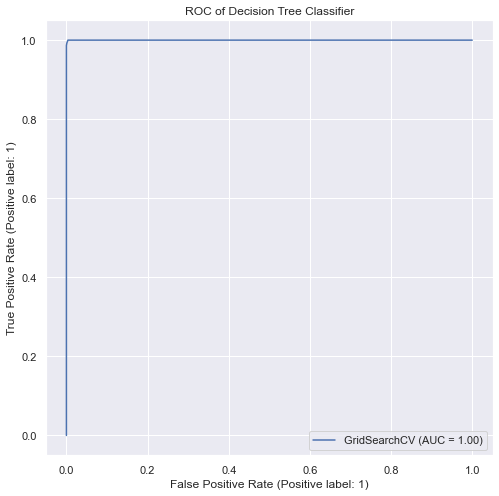


Observation: 
 Built this model with imbalance data and used decison tree model and was able to achieve 100% accuracy and area under the curve is also 100%, as decision tree works really good with small datasets. Even the model's f1-score is 100%


In [28]:
# decision tree with "gini"
dt = DecisionTreeClassifier(random_state = 0, criterion="gini")

# parameters 
parameters = {
                "splitter": ["best","random"],
                "class_weight": [None, "balanced"],
                "max_depth": [9, 11, 13, 15, 17,None]
                }

start_time=time.time()

# grid search for parameters
dt_grid_clf = GridSearchCV(estimator=dt, param_grid=parameters, cv=5,n_jobs=-1)
dt_grid_clf.fit(X_test, Y_test)

# print best scores
print("The best parameters are %s with a score of %0.4f"
      % (dt_grid_clf.best_params_, dt_grid_clf.best_score_))


# prediction results
y_pred = dt_grid_clf.predict(X_test)
y_pred_prob = dt_grid_clf.predict_proba(X_test)

end_time=time.time()##
print("\nRun time for train&test cv (DT-gini): ",end_time-start_time)



# print accuracy metrics
results, false = display_test_scores(Y_test, y_pred,y_pred_prob)
print("\n*************************Decision Tree Classifier****************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_dt_clf = accuracy_score(Y_test,y_pred)
print('Accuracy: %f' % acc_dt_clf )
# precision tp / (tp + fp)
prec_dt_clf  = precision_score(Y_test,y_pred)
print('Precision: %f' % prec_dt_clf )
# recall: tp / (tp + fn)
recall_dt_clf = recall_score(Y_test,y_pred)
print('Recall: %f' % recall_dt_clf )
# f1: 2 tp / (2 tp + fp + fn)
f1_dt_clf = f1_score(Y_test,y_pred)
print('F1 score: %f' % f1_dt_clf )


#plot ROC curve
metrics.plot_roc_curve(dt_grid_clf, X_test, Y_test)
plt.title("ROC of Decision Tree Classifier")
plt.savefig('./images/ROC_DT_Classifier.png')
plt.show()
print("\n\033[1mObservation: \033[0m\n Built this model with imbalance data and used decison tree model and was able to achieve 100% accuracy and area under the curve is also 100%, as decision tree works really good with small datasets. Even the model's f1-score is 100%")

### Decision Tree Classifier with SMOTE

The best parameters are {'class_weight': None, 'max_depth': None, 'splitter': 'random'} with a score of 0.9290

Run time for train&test cv (DT-gini):  0.23231196403503418

*************************Decision Tree Classifier****************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.9266

AUC: 0.9271
CONFUSION MATRIX:
--------------------
[[737  60]
 [ 57 739]]

--------------------
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       797
           1       0.92      0.93      0.93       796

    accuracy                           0.93      1593
   macro avg       0.93      0.93      0.93      1593
weighted avg       0.93      0.93      0.93      1593

Accuracy: 0.926554
Precision: 0.924906
Recall: 0.928392
F1 score: 0.926646


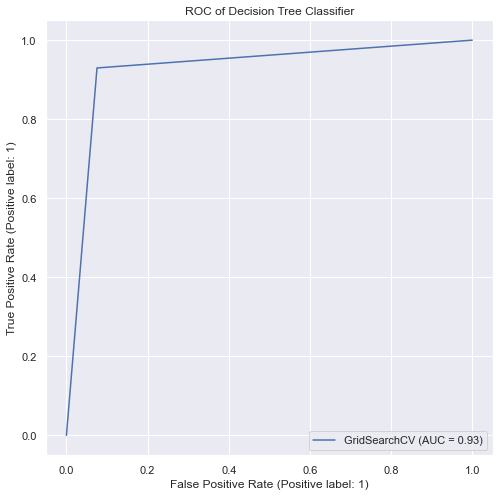


Observation: 
 Built this model with balance data generated using SMOTE technique and used decision tree model and was able to achieve 92% accuracy and area under the curve is 93%. The model's f1-score is 92.65%


In [29]:
# decision tree with "gini"
dt = DecisionTreeClassifier(random_state = 0, criterion="gini")

# parameters 
parameters = {
                "splitter": ["best","random"],
                "class_weight": [None, "balanced"],
                "max_depth": [9, 11, 13, 15, 17,None]
                }

start_time=time.time()

# grid search for parameters
dt_grid_clf = GridSearchCV(estimator=dt, param_grid=parameters, cv=5,n_jobs=-1)
dt_grid_clf.fit(X_smote_train, Y_smote_train)

# print best scores
print("The best parameters are %s with a score of %0.4f"
      % (dt_grid_clf.best_params_, dt_grid_clf.best_score_))


# prediction results
y_pred = dt_grid_clf.predict(X_smote_test)
y_pred_prob = dt_grid_clf.predict_proba(X_smote_test)

end_time=time.time()##
print("\nRun time for train&test cv (DT-gini): ",end_time-start_time)



# print accuracy metrics
results, false = display_test_scores(Y_smote_test, y_pred,y_pred_prob)
print("\n*************************Decision Tree Classifier****************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_dt_clf_smote = accuracy_score(Y_smote_test,y_pred)
print('Accuracy: %f' % acc_dt_clf_smote )
# precision tp / (tp + fp)
prec_dt_clf_smote  = precision_score(Y_smote_test,y_pred)
print('Precision: %f' % prec_dt_clf_smote )
# recall: tp / (tp + fn)
recall_dt_clf_smote = recall_score(Y_smote_test,y_pred)
print('Recall: %f' % recall_dt_clf_smote )
# f1: 2 tp / (2 tp + fp + fn)
f1_dt_clf_smote = f1_score(Y_smote_test,y_pred)
print('F1 score: %f' % f1_dt_clf_smote )
#plot ROC curve
metrics.plot_roc_curve(dt_grid_clf, X_smote_test, Y_smote_test)
plt.title("ROC of Decision Tree Classifier")
plt.savefig('./images/ROC_DT_Classifier_withSMOTE.png')
plt.show()
print("\n\033[1mObservation: \033[0m\n Built this model with balance data generated using SMOTE technique and used decision tree model and was able to achieve 92% accuracy and area under the curve is 93%. The model's f1-score is 92.65%")

### Decision Tree Classifier with undersampling

The best parameters are {'class_weight': 'balanced', 'max_depth': 9, 'splitter': 'best'} with a score of 0.8529

Run time for train&test cv (DT-gini):  0.08028507232666016

*************************Decision Tree Classifier****************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.8519

AUC: 0.8779
CONFUSION MATRIX:
--------------------
[[126  23]
 [ 21 127]]

--------------------
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       149
           1       0.85      0.86      0.85       148

    accuracy                           0.85       297
   macro avg       0.85      0.85      0.85       297
weighted avg       0.85      0.85      0.85       297

Accuracy: 0.851852
Precision: 0.846667
Recall: 0.858108
F1 score: 0.852349


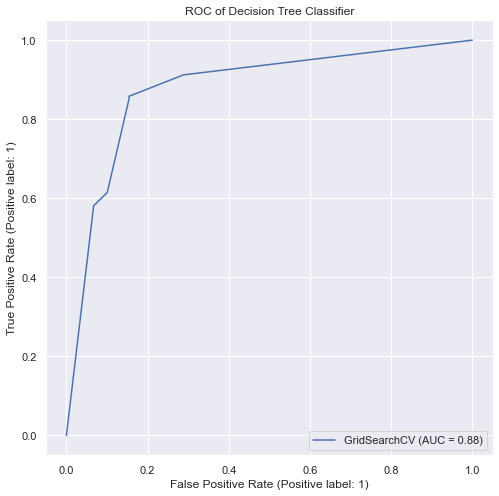


Observation: 
 Built this model with balance data generated using undersampling technique and used decision tree model and was able to achieve 83% accuracy and area under the curve is also 83% which is much less than the previous model(93%). The model's f1-score is 83% which is not an improvement from the previous score 92%.


In [30]:
# decision tree with "gini"
dt = DecisionTreeClassifier(random_state = 0, criterion="gini")

# parameters 
parameters = {
                "splitter": ["best","random"],
                "class_weight": [None, "balanced"],
                "max_depth": [9, 11, 13, 15, 17,None]
                }

start_time=time.time()

# grid search for parameters
dt_grid_clf = GridSearchCV(estimator=dt, param_grid=parameters, cv=5,n_jobs=-1)
dt_grid_clf.fit(X_train_undersampling, Y_train_undersampling)

# print best scores
print("The best parameters are %s with a score of %0.4f"
      % (dt_grid_clf.best_params_, dt_grid_clf.best_score_))


# prediction results
y_pred = dt_grid_clf.predict(X_test_undersampling)
y_pred_prob = dt_grid_clf.predict_proba(X_test_undersampling)

end_time=time.time()##
print("\nRun time for train&test cv (DT-gini): ",end_time-start_time)



# print accuracy metrics
results, false = display_test_scores(Y_test_undersampling, y_pred,y_pred_prob)
print("\n*************************Decision Tree Classifier****************************************\n")
print(results)
# accuracy: (tp + tn) / (p + n)
acc_dt_clf_undersampling = accuracy_score(Y_test_undersampling,y_pred)
print('Accuracy: %f' %  acc_dt_clf_undersampling)
# precision tp / (tp + fp)
prec_dt_clf_undersampling  = precision_score(Y_test_undersampling,y_pred)
print('Precision: %f' % prec_dt_clf_undersampling )
# recall: tp / (tp + fn)
recall_dt_clf_undersampling = recall_score(Y_test_undersampling,y_pred)
print('Recall: %f' % recall_dt_clf_undersampling )
# f1: 2 tp / (2 tp + fp + fn)
f1_dt_clf_undersampling = f1_score(Y_test_undersampling,y_pred)
print('F1 score: %f' % f1_dt_clf_undersampling )
#plot ROC curve
metrics.plot_roc_curve(dt_grid_clf, X_test_undersampling, Y_test_undersampling)
plt.title("ROC of Decision Tree Classifier")
plt.savefig('./images/ROC_DT_Classifier_underSampling.png')
plt.show()
print("\n\033[1mObservation: \033[0m\n Built this model with balance data generated using undersampling technique and used decision tree model and was able to achieve 83% accuracy and area under the curve is also 83% which is much less than the previous model(93%). The model's f1-score is 83% which is not an improvement from the previous score 92%.")

#### TODO: Interactive ROC curve

In [31]:
# def plot_interactive_roc_curve(df, fpr, tpr, thresholds):
#     fig = px.area(
#         data_frame=df, 
#         x=fpr, 
#         y=tpr,
#         hover_data=thresholds, 
#         title='ROC Curve'
#     )
#     fig.update_layout(
#         autosize=False,
#         width=500,
#         height=500,
#         margin=dict(l=30, r=30, b=30, t=30, pad=4),
#         title_x=.5, # Centre title
#         hovermode = 'closest',
#         xaxis=dict(hoverformat='.4f'),
#         yaxis=dict(hoverformat='.4f')
#     )
#     hovertemplate = 'False Positive Rate=%{x}<br>True Positive Rate=%{y}<br>Threshold=%{customdata[0]:.4f}<extra></extra>'
#     fig.update_traces(hovertemplate=hovertemplate)
    
#     # Add dashed line with a slope of 1
#     fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
#     fig.show()
    
# plot_interactive_roc_curve(df=churn_df, 
#                            fpr='false_positive_rate', 
#                            tpr='true_positive_rate', 
#                            thresholds=['threshold'])

### TODO : Final ROC for multiple classifiers

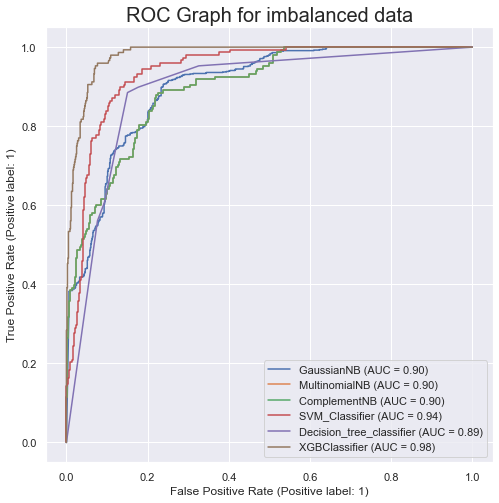


Observation: 
 As we can see from the graph, XGBClassifier has highest area under the curve(98%) for imbalanced data


In [32]:
#without SMOTE

disp = metrics.plot_roc_curve(gaussian_clf, X_smote_test, Y_smote_test)

metrics.plot_roc_curve(Multinomial_clf, X_test, Y_test, ax = disp.ax_)
metrics.plot_roc_curve(ComplementNB_clf, X_test, Y_test, ax = disp.ax_)
metrics.plot_roc_curve(SVM_grid_clf, X_test, Y_test,ax = disp.ax_, name ='SVM_Classifier' )
metrics.plot_roc_curve(dt_grid_clf, X_test, Y_test, ax = disp.ax_, name = 'Decision_tree_classifier')
metrics.plot_roc_curve(xgb, X_test, Y_test, ax = disp.ax_)
plt.savefig('./images/Roc_without_sampling_final.png')
plt.title('ROC Graph for imbalanced data', fontsize = 20)
plt.show()
print("\n\033[1mObservation: \033[0m\n As we can see from the graph, XGBClassifier has highest area under the curve(98%) for imbalanced data")

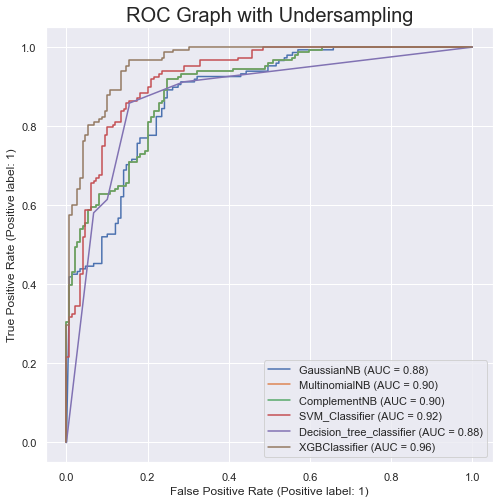


Observation: 
 As we can see from the graph, XGBClassifier has highest area under the curve(96%) for balanced data generated using undersampling technique


In [33]:
# With undersampling
disp = metrics.plot_roc_curve(gaussian_clf, X_test_undersampling, Y_test_undersampling)
metrics.plot_roc_curve(Multinomial_clf, X_test_undersampling, Y_test_undersampling, ax = disp.ax_)
metrics.plot_roc_curve(ComplementNB_clf, X_test_undersampling, Y_test_undersampling, ax = disp.ax_)
metrics.plot_roc_curve(SVM_grid_clf, X_test_undersampling, Y_test_undersampling,ax = disp.ax_, name ='SVM_Classifier' )
metrics.plot_roc_curve(dt_grid_clf, X_test_undersampling, Y_test_undersampling, ax = disp.ax_, name = 'Decision_tree_classifier')
metrics.plot_roc_curve(xgb, X_test_undersampling, Y_test_undersampling, ax = disp.ax_)
plt.savefig('./images/Roc_with_undersampling_final.png')
plt.title('ROC Graph with Undersampling', fontsize = 20)
plt.show()
print("\n\033[1mObservation: \033[0m\n As we can see from the graph, XGBClassifier has highest area under the curve(96%) for balanced data generated using undersampling technique")

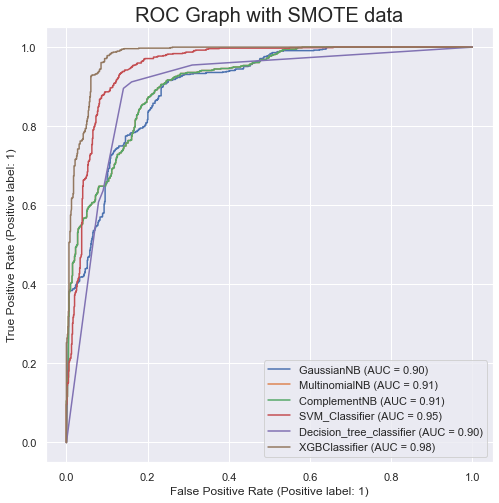


Observation: 
 As we can see from the graph, XGBClassifier has highest area under the curve(98%) for balanced data generated using SMOTE technique


In [34]:
# With SMOTE

disp = metrics.plot_roc_curve(gaussian_clf, X_smote_test, Y_smote_test)
metrics.plot_roc_curve(Multinomial_clf, X_smote_test, Y_smote_test, ax = disp.ax_)
metrics.plot_roc_curve(ComplementNB_clf, X_smote_test, Y_smote_test, ax = disp.ax_)
metrics.plot_roc_curve(SVM_grid_clf, X_smote_test, Y_smote_test,ax = disp.ax_, name ='SVM_Classifier' )
metrics.plot_roc_curve(dt_grid_clf, X_smote_test, Y_smote_test, ax = disp.ax_, name = 'Decision_tree_classifier')
metrics.plot_roc_curve(xgb, X_smote_test, Y_smote_test, ax = disp.ax_)
plt.savefig('./images/Roc_with_SMOTE_final.png')
plt.title('ROC Graph with SMOTE data', fontsize = 20)
plt.show()
print("\n\033[1mObservation: \033[0m\n As we can see from the graph, XGBClassifier has highest area under the curve(98%) for balanced data generated using SMOTE technique")
